In [2]:
import time
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
from untrade.client import Client
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
import talib as t
import warnings
from stockstats import StockDataFrame as sdf
warnings.filterwarnings('ignore')
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# nan_value = np.nan  # Correct way to use NaN

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 965.72it/s]


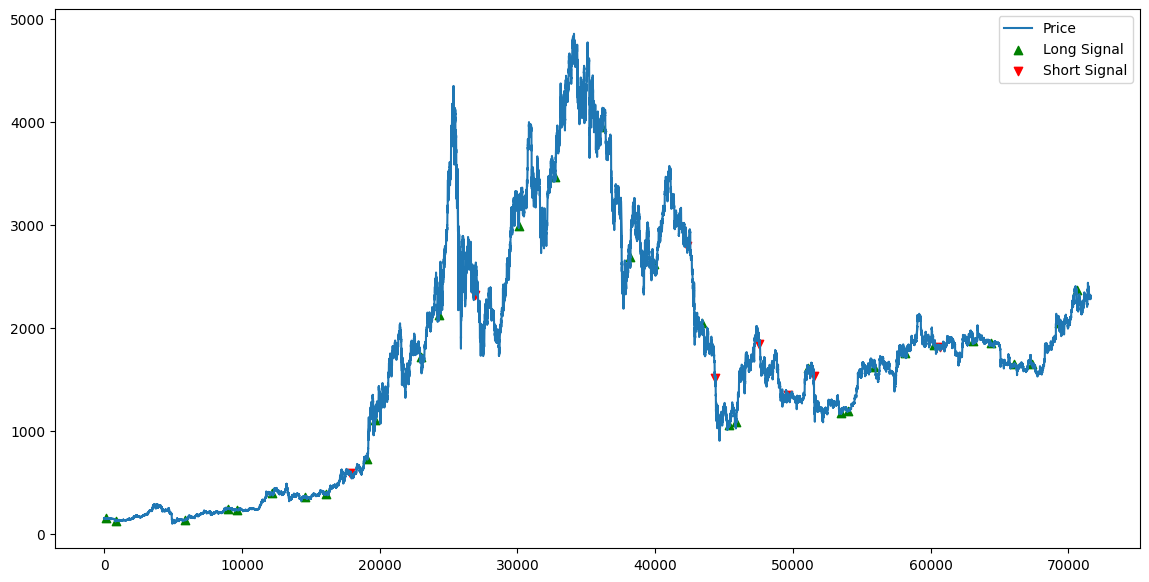

pnl : 5929.904603024141
n_trades: 40
Max_dd_s: 3.979767262284474
Max_dd_comp 17.27491060920477
Max_dd_trade 39


In [3]:
class PnlCalculator:
    def __init__(self, look_back_days, adx_threshold, exit_threshold, atr_multiplier):
        self.look_back_days = look_back_days
        self.adx_threshold = adx_threshold
        self.exit_threshold = exit_threshold
        self.atr_multiplier = atr_multiplier

    def Crossover(self):
        start_time = time.time()

        df = pd.read_csv("ETHUSDT_30m.csv") #Importing coin data(replace file name with local file name)
        df = df.rename(columns={'datetime': 'timestamp'})
        df_btc = pd.read_csv("BTC_2019_2023_30m.csv")
        df_btc = df_btc.iloc[3949:3949+71616]
        df_btc = df_btc.rename(columns={'datetime' : 'timestamp'})

        #Core Signal Generations
        df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        df['HA_Open'] = (df['open'] + df['close']) / 2
        df['HA_Open'] = df['HA_Open'].shift(1)
        df['HA_Open'].iloc[0] = df['open'].iloc[0]
        df['HA_High'] = df[['HA_Open', 'HA_Close']].join(df['high']).max(axis=1)
        df['HA_Low'] = df[['HA_Open', 'HA_Close']].join(df['low']).min(axis=1)

        df['ATR'] = ta.atr(df.HA_High, df.HA_Low, df.HA_Close, window=14)
        df['ATR_ratio'] = df['ATR'] / ((df['ATR'].rolling(window=100).mean()).fillna(1))
        conditions = [
            df['ATR_ratio'] <= 0.8,
            (df['ATR_ratio'] > 0.8) & (df['ATR_ratio'] <= 1.5),
            df['ATR_ratio'] > 1.5
        ]
        
        choices = [-1, 0, 1]
        
        df['ATR_based_volatility'] = np.select(conditions, choices, default=0)  # Default 0 (if missing)        
        df['adx'] = t.ADX(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=self.look_back_days)
        df['+di'] = t.PLUS_DI(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=15)
        df['-di'] = t.MINUS_DI(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=15)
        df['rsi'] = t.RSI(df['HA_Close'], timeperiod=14)
        df['MACD'], df['MACD_signal'], df['MACD_hist'] = t.MACD(df['HA_Close'], fastperiod=12, slowperiod=26, signalperiod=9)

        df['MA_Short'] = ta.sma(df['HA_Close'], length=5)
        df['MA_Long'] = ta.sma(df['HA_Close'], length=20)

        df['HA_Green'] = df['HA_Close'] > df['HA_Open']
        df['HA_Red'] = df['HA_Close'] < df['HA_Open']

        df['Volume_EMA'] = ta.ema(df['volume'],length=14)

        df['Bull_Close'] = df['HA_Close'].diff()
        df['Bull_Open'] = df['HA_Open'].diff()

        df['Bear_Open'] = df['HA_Open'] - df['HA_Close'].shift(1)
        df['Bear_Close'] = df['HA_Close'] - df['HA_Open'].shift(1)

        #btc signal
        df_btc['HA_Close'] = (df_btc['open'] + df_btc['high'] + df_btc['low'] + df_btc['close']) / 4
        df_btc['HA_Open'] = (df_btc['open'] + df_btc['close']) / 2
        df_btc['HA_Open'] = df_btc['HA_Open'].shift(1)
        df_btc['HA_Open'].iloc[0] = df['open'].iloc[0]
        df_btc['HA_High'] = df_btc[['HA_Open', 'HA_Close']].join(df_btc['high']).max(axis=1)
        df_btc['HA_Low'] = df_btc[['HA_Open', 'HA_Close']].join(df_btc['low']).min(axis=1)

        df_btc['ATR'] = ta.atr(df_btc.HA_High, df_btc.HA_Low, df_btc.HA_Close, window=14)
        df_btc['adx'] = t.ADX(df_btc['HA_High'], df_btc['HA_Low'], df_btc['HA_Close'], timeperiod=self.look_back_days)
        df_btc['+di'] = t.PLUS_DI(df_btc['HA_High'], df_btc['HA_Low'], df_btc['HA_Close'], timeperiod=15)
        df_btc['-di'] = t.MINUS_DI(df_btc['HA_High'], df_btc['HA_Low'], df_btc['HA_Close'], timeperiod=15)
        df_btc['rsi'] = t.RSI(df_btc['HA_Close'], timeperiod=14)
        df_btc['MACD'], df_btc['MACD_signal'], df_btc['MACD_hist'] = t.MACD(df_btc['HA_Close'], fastperiod=12, slowperiod=26, signalperiod=9)

        df_btc['MA_Short'] = ta.sma(df_btc['HA_Close'], length=5)
        df_btc['MA_Long'] = ta.sma(df_btc['HA_Close'], length=20)

        df_btc['HA_Green'] = df_btc['HA_Close'] > df_btc['HA_Open']
        df_btc['HA_Red'] = df_btc['HA_Close'] < df_btc['HA_Open']

        df_btc['Signal_Long'] = (df_btc['HA_Green'] & df_btc['HA_Green'].shift(1)) & (df_btc['adx'] > self.adx_threshold) & (df_btc['adx'].shift(1) < self.adx_threshold) 
        df_btc['Signal_Short'] = (df_btc['HA_Red']& df_btc['HA_Red'].shift(1)) & (df_btc['MA_Short'] > df_btc['MA_Long']) & (df_btc['adx'] > self.adx_threshold) & (df_btc['adx'].shift(1) < self.adx_threshold)

        df_btc['signals'] = np.where(df_btc['Signal_Long'],1,np.where(df_btc['Signal_Short'],2,0))
        df_btc['signals'] = np.where((df_btc['rsi']<70) & (df_btc['rsi']>30),df_btc['signals'],0)

        # Calculate percentage changes
        df['ETH_pct_change'] = df['HA_Close'].pct_change()
        df_btc['BTC_pct_change'] = df_btc['HA_Close'].pct_change()
        
        # Merge BTC and ETH dataframes
        df_combined = df.merge(df_btc[['timestamp', 'BTC_pct_change']], on='timestamp', how='left')
        
        # Calculate rolling correlation
        correlation_window = 7 #38         10,8,7
        df_combined['correlation'] = df_combined['ETH_pct_change'].rolling(window=correlation_window).corr(df_combined['BTC_pct_change'])
        
        # Define correlation threshold
        correlation_threshold = 0.9   #0.84
        
        # Generate signals with correlation filter
        df_combined['Signal_Long'] = (df_combined['HA_Green'] & df_combined['HA_Green'].shift(-1) & df_combined['HA_Red'].shift(1)) & \
                                     ((df_combined['Bull_Close']>0) & ((df_combined['Bull_Open'])<0)) &\
                                     (df_combined['adx'] > self.adx_threshold) & \
                                     (df_combined['adx'].shift(1) < self.adx_threshold) & \
                                     (df_combined['correlation'] > correlation_threshold)
        
        df_combined['Signal_Short'] = (df['HA_Red'] & df['HA_Red'].shift(-1) & df['HA_Green'].shift(1)) & \
                                      ((df['Bear_Close']<0) & ((df['Bear_Open'])>0)) & \
                                      (df_combined['adx'] > self.adx_threshold) & \
                                      (df_combined['adx'].shift(1) < self.adx_threshold) & \
                                      (df_combined['correlation'] > correlation_threshold)

        # Assign signals
        df_combined['signals'] = 0
        df_combined.loc[df_combined['Signal_Long'], 'signals'] = 1
        df_combined.loc[df_combined['Signal_Short'], 'signals'] = 2
        df_combined['signals'] = np.where((df_combined['rsi']<70) & (df_combined['rsi']>30),df_combined['signals'],0)
        
        #df_combined for backtesting
        df = df_combined

    

        in_trade_long, in_trade_short = False, False
        df['remarks'] = 'Algo_Exit'

        for i in tqdm(range(len(df))):
            if df['signals'].iloc[i - 1] == -1:
                df.at[i, 'signals'] = 2
                in_trade_short = True
            if df['signals'].iloc[i - 1] == -2:
                df.at[i, 'signals'] = 1
                in_trade_long = True
            if df['signals'].iloc[i] == 2 and in_trade_long:
                df.at[i, 'signals'] = -1
                in_trade_long = False
            elif df['signals'].iloc[i] == 1 and in_trade_short:
                df.at[i, 'signals'] = -2
                in_trade_short = False
            elif df['signals'].iloc[i] == 2 and not in_trade_short:
                in_trade_short = True
                in_trade_long = False
            elif df['signals'].iloc[i] == 1 and not in_trade_long:
                in_trade_long = True
                in_trade_short = False

        sl, entry_price, target_points = 0, 0, 0
        trailing_sl, intrade_long, intrade_short = 0, False, False
        max_drawdown_reached = False
        cumulative_profit = 0

        
        for i in tqdm(range(len(df))):
            atr_mult = (lambda x: 15 if x['ATR_based_volatility'] == -1 
            else 20 if x['ATR_based_volatility'] == 0 
            else 30)(df.iloc[i])  # Call the function with df.iloc[i]

            if df['signals'].iloc[i] == 1:
                entry_price = df["HA_Close"].iloc[i]
                sl = df["HA_Close"].iloc[i] - (atr_mult * df['ATR'].iloc[i])
                trailing_sl = sl
                intrade_long = True
                target_points = 70 * df['ATR'].iloc[i]
            elif df['signals'].iloc[i] == 2:
                entry_price = df["HA_Close"].iloc[i]
                sl = df["HA_Close"].iloc[i] + (atr_mult * df['ATR'].iloc[i])
                trailing_sl = sl
                intrade_short = True
                target_points = 27 * df['ATR'].iloc[i]
            elif intrade_short:
                if df['HA_Close'].iloc[i] < entry_price - target_points  or df['HA_Close'].iloc[i] > sl:
                    df['signals'].iloc[i] = -2
                    df['remarks'].iloc[i] = 'SL_Exit'
                    intrade_short = False
                else:
                    # atr_mult = (lambda x: 10 if (x['ATR_based_volatility']==-1) else 15 if (x['ATR_based_volatility']==0) else 20)(df.iloc[i])
                    trailing_sl = min(trailing_sl, df['HA_Close'].iloc[i] + (atr_mult * df['ATR'].iloc[i]))
                    if df['HA_Close'].iloc[i] >= trailing_sl:
                        df['signals'].iloc[i] = -2
                        df['remarks'].iloc[i] = 'Trailing_SL_Exit'
                        intrade_short = False
            elif intrade_long:
                if df['HA_Close'].iloc[i] > entry_price + target_points or  df['HA_Close'].iloc[i] < sl:
                    df['signals'].iloc[i] = -1
                    df['remarks'].iloc[i] = 'SL_Exit'
                    intrade_long = False
                else:
                    trailing_sl = max(trailing_sl, df['HA_Close'].iloc[i] - (atr_mult * df['ATR'].iloc[i]))
                    if df['HA_Close'].iloc[i] <= trailing_sl:
                        df['signals'].iloc[i] = -1
                        df['remarks'].iloc[i] = 'Trailing_SL_Exit'
                        intrade_long = False

        df_1 = df
        long_open = False
        short_open = False

        for index, row in df_1.iterrows():
            signal = row['signals']

            if signal == 2 and short_open:
                df_1.at[index, 'signals'] = 0
            elif signal == 1 and long_open:
                df_1.at[index, 'signals'] = 0
            elif signal == 1 and long_open != True:
                long_open = True
            elif signal == 2 and short_open != True:
                short_open = True

            elif signal == -1:
                if long_open:
                    long_open = False
                else:
                    df_1.at[index, 'signals'] = 0
            elif signal == -2:
                if short_open:
                    short_open = False
                else:
                    df_1.at[index, 'signals'] = 0


                    ####END OF SIGNAL GENERATION#####
        # print(df['ATR_ratio'].max(skipna=True))
        # print(df['ATR_based_volatility'].value_counts())
        ###BACKTESTING#####

        df_1['signal'] = df_1['signals']
        df_1.to_csv('signals.csv')
        dg = df_1[df_1['signal'] != 0]
        

        dg['entry_price'] = dg['close']
        dg['entry_timestamp'] = dg['timestamp']
        dg['exit_price'] = dg['entry_price'].shift(-1)
        dg['exit_timestamp'] = dg['timestamp'].shift(-1)
        pnl = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal', 'remarks']]


        ##for static statistics

        pnl['profit_per_btc'] = np.where(pnl['signal'] == 1, pnl['exit_price'] - pnl['entry_price'], 
                                        np.where(pnl['signal'] == 2, pnl['entry_price'] - pnl['exit_price'], None)) 
        pnl['capital'] = 1000
        pnl['#units'] = pnl['capital'] / pnl['entry_price']
        pnl['profit_per_capital'] = pnl['#units'] * pnl['profit_per_btc']
        pnl['tnc_cost'] = 1.5
        pnl['profit_after_tnc'] = pnl['profit_per_capital'] - pnl['tnc_cost']
        pnl['cumulative_profit'] = pnl['profit_after_tnc'].cumsum       ###BACKTESTING#####

        df_1['signal'] = df_1['signals']
        df_1.to_csv('signals.csv')
        dg = df_1[df_1['signal'] != 0]
        

        dg['entry_price'] = dg['close']
        dg['entry_timestamp'] = dg['timestamp']
        dg['exit_price'] = dg['entry_price'].shift(-1)
        dg['exit_timestamp'] = dg['timestamp'].shift(-1)
        pnl = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal', 'remarks']]


        ##for static statistics

        pnl['profit_per_btc'] = np.where(pnl['signal'] == 1, pnl['exit_price'] - pnl['entry_price'], 
                                        np.where(pnl['signal'] == 2, pnl['entry_price'] - pnl['exit_price'], None)) 
        pnl['capital'] = 1000
        pnl['#units'] = pnl['capital'] / pnl['entry_price']
        pnl['profit_per_capital'] = pnl['#units'] * pnl['profit_per_btc']
        pnl['tnc_cost'] = 1.5
        pnl['profit_after_tnc'] = pnl['profit_per_capital'] - pnl['tnc_cost']
        pnl['cumulative_profit'] = pnl['profit_after_tnc'].cumsum()
        pnl['roe_%'] = (pnl['profit_after_tnc'] / pnl['capital']) * 100
        net_pnl = pnl.reset_index()
        n_trades = pnl.shape[0]
        pnl['c_f'] = pnl['cumulative_profit'] + 1000
        peak = 1000
        max_drawdown = 0
        for value in pnl['c_f']:
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown

        max_drawdown_percentage_static = max_drawdown * 100

        ##for compounding statistics
        d = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal']]
        d['profit_per_eth'] = np.where(d['signal'] == 1, d['exit_price'] - d['entry_price'], 
                                                 np.where(d['signal'] == 2, d['entry_price'] - d['exit_price'], None))
        d['tnc_cost'] = 1.5
        d['capital'] = 1000
        d['units'] = 1000 / d['entry_price']
        d['profit_per_capital'] = d['units'] * d['profit_per_eth']
        d['profit_after_tnc'] = d['profit_per_capital'] - d['tnc_cost']
        #d['cumulative_profit'] = 0
        
        for i in tqdm(range(1, len(d))):
            d['capital'].iloc[i] = d['capital'].iloc[i - 1] + d['profit_after_tnc'].iloc[i - 1]
            d['capital'].iloc[i]/=1.0015
            d['units'].iloc[i] = d['capital'].iloc[i] / d['entry_price'].iloc[i]
            d['profit_per_capital'].iloc[i] = d['units'].iloc[i] * d['profit_per_eth'].iloc[i]
            d['profit_after_tnc'].iloc[i] = d['profit_per_capital'].iloc[i] - d['tnc_cost'].iloc[i]
            #d['cumulative_profit'].iloc[i] = d['capital'].iloc[i-1] + d['cumulative_profit'].iloc[i] + d['profit_after_tnc'].iloc[i]

        d['c_f'] = d['capital']
        peak = 1000
        max_drawdown = 0
        max_dd_trade_time = 0
        max_dd_index = 0 

        for i, value in enumerate(d['c_f']):
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
                max_dd_index = i

        max_drawdown_percentage_compounding = max_drawdown * 100

        end_time = time.time()
        time_taken = end_time - start_time


        ##visualising signals
        plt.figure(figsize=(14, 7))
        plt.plot(df['close'], label='Price')
        plt.scatter(df[df['signals'] == 1].index, df[df['signals'] == 1]['close'], marker='^', color='g', label='Long Signal', alpha=1)
        plt.scatter(df[df['signals'] == 2].index, df[df['signals'] == 2]['close'], marker='v', color='r', label='Short Signal', alpha=1)
        plt.legend()
        plt.show()

        return net_pnl, net_pnl['profit_after_tnc'].sum(), time_taken, max_drawdown_percentage_static, n_trades, max_drawdown_percentage_compounding, max_dd_index 


if __name__ == "__main__":
    pnl_calculator = PnlCalculator(
        look_back_days=10, 
        adx_threshold=31, 
        exit_threshold=86, 
        atr_multiplier=15)  # Create an instance of PnlCalculator 
    obj, net_pnl_amount, time_taken, max_drawdown_percentage_static, n_trades, max_drawdown_percentage_compounding, max_dd_index = pnl_calculator.Crossover()

    obj.to_csv('pnl_since_2019.csv', index=False)
    
    print("pnl :", net_pnl_amount)
    print("n_trades:", n_trades)
    print("Max_dd_s:", max_drawdown_percentage_static)
    print("Max_dd_comp", max_drawdown_percentage_compounding)
    print("Max_dd_trade", max_dd_index)


#******************************************************midterm_strategy****************************************************************************************




In [4]:
def strat(data):
    dg = data
    for i in tqdm(range(len(dg))):
        if dg['signals'].iloc[i] == 2 :
            dg['signals'].iloc[i] = -1
        elif dg['signals'].iloc[i] == -2 :
            dg['signals'].iloc[i] = 1
    return dg



In [5]:
def perform_backtest(csv_file_path):
    client = Client()

    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="niruiit",  # the one you use to login to jupyter.untrade.io
        file_path=csv_file_path,
        leverage=1,# Adjust leverage as needed
    )
    return result



In [6]:
if __name__ == "__main__":
    # Read data from CSV file
    data = pd.read_csv("signals.csv")
    data = data[data["signals"]!=0]
    data = data.rename(columns={'timestamp': 'datetime'})
    res1 = strat(data)
    res = (res1)
    res.to_csv("processed_data.csv", index=False)

    # Perform backtest on processed data
    csv_file_path = "processed_data.csv"
    backtest_result = perform_backtest(csv_file_path)

    # Get the last value of backtest result
    last_value = None
    for value in backtest_result:
        print(value)  # Uncomment to see the full backtest result (backtest_result is a generator object)
        last_value = value
    print(last_value)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 10954.40it/s]


None
